# Classification NBA Model

## Configuration

## Imports

In [73]:
import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import KFold, cross_validate, train_test_split
try:
    from utils import clean_dataframe_for_training
except ImportError:
    from nba_ou.data_preparation.missing_data.clean_df_for_training import (
        clean_dataframe_for_training
    )

## Load Data

In [74]:
data_path = "/home/adrian_alvarez/Projects/NBA_over_under_predictor/data/train_data/"
name = "all_odds_training_data_until_20260120.csv"

path = data_path + name

# path = "/home/coder/repos/terminus-eu-complian/data/energy_labels_tabular.csv"

df_stats = pd.read_csv(path)

dtype_dict = {col: str for col in df_stats.columns if "ID" in col.upper()}

df_stats = pd.read_csv(
    path,
    dtype=dtype_dict
)
df_stats['GAME_DATE'] = pd.to_datetime(df_stats['GAME_DATE']).dt.strftime('%Y-%m-%d')

/tmp/ipykernel_1746713/3116795649.py:8: DtypeWarning: Columns (497,498,499,540,541,542,583,584,585,626,627,628,669,670,671,712,713,714,1200,1201,1202,1243,1244,1245,1286,1287,1288,1329,1330,1331,1372,1373,1374,1415,1416,1417) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stats = pd.read_csv(path)
/tmp/ipykernel_1746713/3116795649.py:12: DtypeWarning: Columns (497,498,499,540,541,542,583,584,585,626,627,628,669,670,671,712,713,714,1200,1201,1202,1243,1244,1245,1286,1287,1288,1329,1330,1331,1372,1373,1374,1415,1416,1417) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stats = pd.read_csv(


In [75]:
# #print column names with name in lower case
# for col in df_stats.columns:
#     if not col.isupper():
#         print(col)

In [76]:
#filter for last two seasons, gett seasons 2025 and 2024
# df_stats = df_stats[df_stats['SEASON_YEAR'].isin([2024, 2025])]

In [77]:
df_stats

,TOTAL_OVER_UNDER_LINE,TEAM_ID_TEAM_HOME,TEAM_CITY_TEAM_HOME,TEAM_ABBREVIATION_TEAM_HOME,TEAM_NAME_TEAM_HOME,MATCHUP_TEAM_HOME,GAME_NUMBER_TEAM_HOME,TEAM_ID_TEAM_AWAY,TEAM_CITY_TEAM_AWAY,TEAM_ABBREVIATION_TEAM_AWAY,...,TRAVEL_RECENCY_RATIO_AWAY_2D_OVER_14D,REST_DAYS_DIFF_HOME_MINUS_AWAY,INJURY_PTS_SHARE_HOME,INJURY_PTS_SHARE_AWAY,STAR_PTS_PCT_DIFF_HOME_MINUS_AWAY,POSS_X_TSPCT_HOME,POSS_X_TSPCT_AWAY,IS_WEEKEND,MONTH,IS_US_HOLIDAY
0,225.0,1610612744,Golden State,GSW,Golden State Warriors,GSW vs. TOR,45,1610612761,Toronto,TOR,...,0.911623,-1,0.342942,0.334240,0.035261,59.681545,56.186177,0,1,0
1,238.5,1610612762,Utah,UTA,Utah Jazz,UTA vs. MIN,44,1610612750,Minnesota,MIN,...,0.000000,-2,0.464479,0.038945,-0.044902,60.155182,61.740477,0,1,0
2,228.0,1610612743,Denver,DEN,Denver Nuggets,DEN vs. LAL,44,1610612747,Los Angeles,LAL,...,0.787565,0,0.434814,0.309755,-0.078416,59.305288,58.197857,0,1,0
3,220.5,1610612745,Houston,HOU,Houston Rockets,HOU vs. SAS,41,1610612759,San Antonio,SAS,...,0.000000,1,0.050331,0.171602,0.010694,56.478101,57.227952,0,1,0
4,238.5,1610612758,Sacramento,SAC,Sacramento Kings,SAC vs. MIA,44,1610612748,Miami,MIA,...,0.900145,1,0.134210,0.209058,-0.022231,55.800122,59.403170,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10865,NaN,1610612763,Memphis,MEM,Memphis Grizzlies,MEM vs. NOP,1,1610612740,New Orleans,NOP,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,10,0
10866,NaN,1610612738,Boston,BOS,Boston Celtics,BOS vs. MIL,2,1610612749,Milwaukee,MIL,...,NaN,1,NaN,NaN,NaN,NaN,NaN,0,10,0
10867,NaN,1610612742,Dallas,DAL,Dallas Mavericks,DAL vs. ATL,1,1610612737,Atlanta,ATL,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,10,0
10868,NaN,1610612739,Cleveland,CLE,Cleveland Cavaliers,CLE vs. BOS,1,1610612738,Boston,BOS,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,10,0


In [78]:
df_to_train = clean_dataframe_for_training(df_stats, nan_threshold=3, drop_all_na_rows=True,keep_columns =['GAME_DATE', 'TEAM_NAME_TEAM_HOME', 'TEAM_NAME_TEAM_AWAY'], verbose=1)


STARTING DATAFRAME CLEANING PIPELINE
Starting basic cleaning with 10870 rows
Basic cleaning complete: 8050 rows remaining

Starting advanced column cleaning with 1805 columns

Advanced column cleaning complete: 1805 → 819 columns (986 removed)


Dropping NA rows for SEASON_YEAR 2017...
   Removed 0 rows with NaN values from 2017 season

Applying missing data policy...

Missing Data Policy Report:
  Rows dropped: 0 (0.0%)
  Critical columns requiring data: 5
  Columns zero-filled: 132
  Infer pairs applied: 54/228
  Remaining NaN cells: 14638

Dropping rows that are all NaN...
CLEANING COMPLETE
Final shape: (7194, 819)


In [79]:
# Count NAs per column
na_counts = df_to_train.isna().sum()

# Get most common SEASON_YEAR for nulls in each column
most_common_season = []
for col in df_to_train.columns:
    if na_counts[col] > 0:
        # Get rows where this column is null
        null_rows = df_stats[df_stats[col].isna()]
        if len(null_rows) > 0 and 'SEASON_YEAR' in df_stats.columns:
            # Find most common SEASON_YEAR for these null rows
            common_season = null_rows['SEASON_YEAR'].mode()
            most_common_season.append(common_season.iloc[0] if len(common_season) > 0 else None)
        else:
            most_common_season.append(None)
    else:
        most_common_season.append(None)

na_counts_df = pd.DataFrame({
    'Column': na_counts.index,
    'NA_Count': na_counts.values,
    'NA_Percentage': (na_counts.values / len(df_to_train) * 100).round(2),
    'Most_Common_Season_Year': most_common_season
}).sort_values('NA_Count', ascending=False)

# Show only columns with NAs
na_counts_df[na_counts_df['NA_Count'] > 0]

,Column,NA_Count,NA_Percentage,Most_Common_Season_Year


In [80]:
df_to_train['LINE_ERROR'] = df_to_train['TOTAL_POINTS'] - df_to_train['TOTAL_OVER_UNDER_LINE']

In [81]:
# df_to_train = df_to_train[df_to_train['LINE_ERROR'] != 0]

## Train / Test

In [82]:
import numpy as np
import pandas as pd

from tabpfn_time_series import TabPFNTSPipeline, TabPFNMode
from tabpfn_time_series.plot import plot_forecast

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def build_ts_frames(
    df: pd.DataFrame,
    timestamp_col: str = "GAME_DATE",
    target_col: str = "LINE_ERROR",
    col_item_id: str = None,
    drop_leakage_cols: tuple[str, ...] = ("TOTAL_POINTS",),
) -> pd.DataFrame:
    """
    Produce a TabPFN TS-compatible long dataframe:
    columns: item_id, timestamp, target, + covariates
    """
    out = df.copy()

    # timestamp must be datetime, not string
    out[timestamp_col] = pd.to_datetime(out[timestamp_col], errors="coerce")
    out = out.dropna(subset=[timestamp_col])

    if col_item_id is not None:
        out["item_id"] = out[col_item_id]
    else:
        out["item_id"] = "NBA"

    out["timestamp"] = out[timestamp_col]
    out["target"] = pd.to_numeric(out[target_col], errors="coerce")

    # Drop obvious leakage columns and non covariate columns
    to_drop = {timestamp_col, target_col,col_item_id, "SEASON_YEAR", "item_id", "timestamp", "target"}
    to_drop |= set(drop_leakage_cols)

    covariate_cols = [c for c in out.columns if c not in to_drop]

    tsdf = out[["item_id", "timestamp", "target"] + covariate_cols].sort_values(
        ["item_id", "timestamp"]
    )

    # Remove rows with missing target in the historical context
    tsdf = tsdf.dropna(subset=["target"])

    return tsdf



In [83]:
import numpy as np
import pandas as pd

HOME_SUFFIX = "_TEAM_HOME"
AWAY_SUFFIX = "_TEAM_AWAY"

def make_team_panel_from_games(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"], errors="coerce")
    df = df.dropna(subset=["GAME_DATE"])

    # Target at game level
    df["LINE_ERROR"] = df["TOTAL_POINTS"] - df["TOTAL_OVER_UNDER_LINE"]

    home = df.copy()
    away = df.copy()

    home["item_id"] = home["TEAM_NAME_TEAM_HOME"]
    away["item_id"] = away["TEAM_NAME_TEAM_AWAY"]

    home["IS_HOME"] = 1
    away["IS_HOME"] = 0

    home["OPPONENT"] = home["TEAM_NAME_TEAM_AWAY"]
    away["OPPONENT"] = away["TEAM_NAME_TEAM_HOME"]

    # Unify *_TEAM_HOME and *_TEAM_AWAY -> *_TEAM
    home_cols = [c for c in df.columns if c.endswith(HOME_SUFFIX)]
    for c_home in home_cols:
        base = c_home[: -len(HOME_SUFFIX)]
        c_away = base + AWAY_SUFFIX
        if c_away in df.columns:
            home[base + "_TEAM"] = home[c_home]
            away[base + "_TEAM"] = away[c_away]

    # Drop original paired columns to reduce dimensionality
    drop_pair_cols = []
    for c_home in home_cols:
        base = c_home[: -len(HOME_SUFFIX)]
        c_away = base + AWAY_SUFFIX
        if c_away in df.columns:
            drop_pair_cols.extend([c_home, c_away])

    home = home.drop(columns=drop_pair_cols, errors="ignore")
    away = away.drop(columns=drop_pair_cols, errors="ignore")

    panel = pd.concat([home, away], ignore_index=True)

    # Keep only what you need; do NOT keep TOTAL_POINTS in covariates
    panel = panel.drop(columns=["TOTAL_POINTS"], errors="ignore")

    # Rename for TabPFN TS
    panel = panel.rename(columns={"GAME_DATE": "timestamp", "LINE_ERROR": "target"})

    # Final ordering
    panel = panel.sort_values(["item_id", "timestamp"]).dropna(subset=["target"])

    return panel


In [84]:
tsdf = make_team_panel_from_games(df_to_train)

N_CONTEXT = 15  # tune this

tmp = (
    tsdf.groupby("item_id", group_keys=False)
        .tail(N_CONTEXT + 1)
        .copy()
)

test_df = tmp.groupby("item_id", group_keys=False).tail(1).copy()
context_df = tmp.drop(index=test_df.index).copy()
future_df = test_df.drop(columns=["target"]).copy()


/tmp/ipykernel_1746713/783882394.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  home[base + "_TEAM"] = home[c_home]
/tmp/ipykernel_1746713/783882394.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  away[base + "_TEAM"] = away[c_away]
/tmp/ipykernel_1746713/783882394.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

In [85]:
# Run TabPFN TS
pipeline = TabPFNTSPipeline(tabpfn_mode=TabPFNMode.CLIENT, tabpfn_model_config={"ignore_pretraining_limits": True},
)  # or TabPFNMode.CLIENT
pred_df = pipeline.predict_df(
    context_df=context_df,
    future_df=future_df,
    # If your version supports custom quantiles you can pass them, otherwise omit.
    # quantiles=[0.1, 0.5, 0.9],
)


Predicting time series:  27%|██▋       | 8/30 [00:00<00:00, 31.31it/s]

  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.


Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]6/30 [00:14<00:14,  1.03s/it]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Predicting time series: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:

MSE: 432.6706679670262
MAE: 15.448268635074298
R2 : -0.2757825560146532


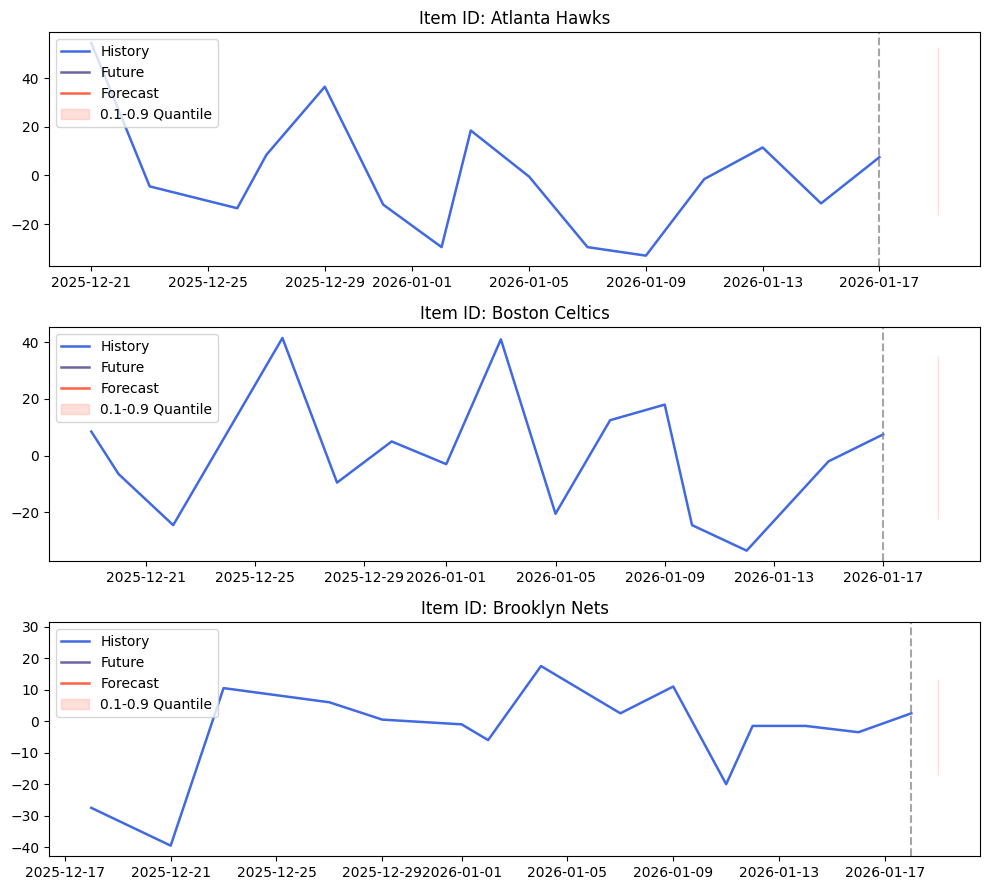

In [86]:

# Merge predictions with ground truth
pred_reset = pred_df.reset_index()  # expects item_id,timestamp index in the returned df
eval_df = test_df.merge(pred_reset, on=["item_id", "timestamp"], how="left", validate="one_to_one")

# Pick the median forecast (handle both float and string column naming)
q50_col = 0.6 if 0.6 in eval_df.columns else "0.6"
y_true = eval_df["target_x"].to_numpy(dtype=float)
y_pred = eval_df[q50_col].to_numpy(dtype=float)

print("MSE:", mean_squared_error(y_true, y_pred))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R2 :", r2_score(y_true, y_pred))

# Optional: visualize
some_teams = context_df["item_id"].unique()[:3].tolist()
plot_forecast(context_df, pred_df, test_df=test_df, item_ids=some_teams)

In [90]:
pred_reset['real_target'] = y_true

In [115]:
pred_reset['EQUAL_SIGN'] = np.sign(pred_reset[0.3]) == np.sign(pred_reset['real_target'])    

In [116]:
pred_reset['EQUAL_SIGN'].mean()

np.float64(0.5333333333333333)

In [94]:
pred_reset

,item_id,timestamp,target,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,real_target,EQUAL_SIGN
0,Atlanta Hawks,2026-01-19,15.832950,-16.100513,-5.412630,2.229122,9.157075,15.832950,22.577715,30.141556,39.193413,52.688961,-10.5,False
1,Boston Celtics,2026-01-19,4.270801,-22.399115,-13.344881,-6.693311,-1.067100,4.270801,9.822661,15.954993,23.545572,35.144966,-16.5,False
2,Brooklyn Nets,2026-01-19,1.039439,-16.929716,-9.357346,-4.938383,-1.699283,1.039439,3.665360,6.336022,9.331728,13.375664,28.0,True
3,Charlotte Hornets,2026-01-18,2.704210,-31.492683,-17.505150,-8.486607,-2.167296,2.704210,6.793981,10.568923,14.356621,18.534430,-29.5,False
4,Chicago Bulls,2026-01-20,-6.301965,-27.397562,-20.804291,-15.255261,-10.365914,-6.301965,-2.588579,1.548486,7.043067,17.418812,23.0,False
5,Cleveland Cavaliers,2026-01-19,7.572609,-9.055605,-2.231691,1.968663,5.125988,7.572609,9.581729,11.375101,13.226167,15.615561,10.5,True
6,Dallas Mavericks,2026-01-19,3.868217,-17.623167,-9.692545,-4.386378,-0.027954,3.868217,7.882739,12.091067,16.910215,23.643436,-21.0,False
7,Denver Nuggets,2026-01-20,3.459576,-9.522491,-3.111636,-0.117555,1.855658,3.459576,4.985457,6.599005,8.459575,11.172576,-6.0,False
8,Detroit Pistons,2026-01-19,-14.458684,-33.200062,-26.706751,-22.237907,-18.295120,-14.458684,-10.398661,-5.603191,0.450014,10.036070,-16.5,True
9,Golden State Warriors,2026-01-20,3.415847,-12.307492,-6.299365,-2.288744,0.791146,3.415847,5.845413,8.250743,10.846850,14.314389,47.0,True


In [87]:
def error_sign_accuracy(y_true_error, y_pred_error, include_pushes: bool = False) -> float:
    y_true_error = np.asarray(y_true_error, dtype=float)
    y_pred_error = np.asarray(y_pred_error, dtype=float)

    true_sign = np.sign(y_true_error)
    pred_sign = np.sign(y_pred_error)

    if include_pushes:
        valid = ~((true_sign == 0) ^ (pred_sign == 0))
    else:
        valid = (true_sign != 0) & (pred_sign != 0)

    if not np.any(valid):
        return np.nan

    return float(np.mean(true_sign[valid] == pred_sign[valid]))

print("Directional accuracy:", error_sign_accuracy(y_true, y_pred))


Directional accuracy: 0.5


In [88]:
acc = error_sign_accuracy(future_df_target['target'], pred_df['target'])
acc

0.43333333333333335

In [66]:
future_df_target['target'], pred_df['target']

(12   -10.5
 79   -24.5
 13    28.0
 94    -4.5
 6     23.0
 11    10.5
 29    17.5
 2     -6.0
 7    -16.5
 0     47.0
 3     -3.5
 34     5.0
 47    -6.5
 16   -24.0
 66   -20.0
 30     7.0
 56    15.5
 74    -2.5
 51    -1.5
 8    -21.0
 59    -6.5
 75    10.0
 5      3.5
 69    -3.5
 27    24.5
 4      8.5
 10    -5.5
 33     2.5
 1     10.5
 9    -10.5
 Name: target, dtype: float64,
 item_id                 timestamp 
 Atlanta Hawks           2026-01-19    -2.385623
 Boston Celtics          2026-01-10     1.610413
 Brooklyn Nets           2026-01-19    -7.151618
 Charlotte Hornets       2026-01-08   -11.144878
 Chicago Bulls           2026-01-20    -7.108352
 Cleveland Cavaliers     2026-01-19    -6.173242
 Dallas Mavericks        2026-01-17     4.646201
 Denver Nuggets          2026-01-20    -5.400991
 Detroit Pistons         2026-01-19   -10.568137
 Golden State Warriors   2026-01-20    -0.023090
 Houston Rockets         2026-01-20    -5.077960
 Indiana Pacers          2026-01-1

In [48]:
pred_df

,,target,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
item_id,timestamp,,,,,,,,,,
Atlanta Hawks,2026-01-19,0.299541,-21.001337,-13.985472,-8.801672,-4.170809,0.299541,4.998110,10.214440,16.680250,26.570463
Boston Celtics,2026-01-10,-1.812644,-25.085289,-17.436117,-11.623791,-6.534032,-1.812644,2.847195,7.848063,13.550707,21.295923
Brooklyn Nets,2026-01-19,-4.437188,-22.561529,-15.800503,-11.314244,-7.700501,-4.437188,-1.356712,1.820348,5.363734,10.057092
Charlotte Hornets,2026-01-08,-7.030233,-26.148350,-19.390039,-14.719706,-10.770700,-7.030233,-3.279019,0.827020,5.656714,12.370487
Chicago Bulls,2026-01-20,-5.437756,-24.956551,-17.751722,-12.763017,-8.551942,-5.437756,-2.718884,-0.281987,2.187643,6.016189
Cleveland Cavaliers,2026-01-19,-5.099513,-27.600485,-19.976870,-14.377234,-9.541959,-5.099513,-0.709900,3.917987,9.111894,15.940950
Dallas Mavericks,2026-01-17,4.807430,-18.139185,-10.363426,-4.645287,0.194619,4.807430,9.385935,14.222543,19.975060,28.001055
Denver Nuggets,2026-01-20,-8.050804,-37.412117,-27.362638,-20.113758,-13.942307,-8.050804,-2.205299,4.208414,11.621472,22.004656
Detroit Pistons,2026-01-19,-6.882293,-33.810955,-25.136961,-18.461832,-12.479519,-6.882293,-1.383348,4.345361,10.457820,17.946198


In [36]:
future_df_target['target']

12   -10.5
79   -24.5
13    28.0
94    -4.5
6     23.0
11    10.5
29    17.5
2     -6.0
7    -16.5
0     47.0
3     -3.5
34     5.0
47    -6.5
16   -24.0
66   -20.0
30     7.0
56    15.5
74    -2.5
51    -1.5
8    -21.0
59    -6.5
75    10.0
5      3.5
69    -3.5
27    24.5
4      8.5
10    -5.5
33     2.5
1     10.5
9    -10.5
Name: target, dtype: float64